# Project: Bennu Asteroid Image Processing
## 1 - Classification of Fracture's Direction
## Table of Contents
<ul>
<li><a href="#1">Parse DS9 Regions File</a></li>
<li><a href="#2">Direction Classification</a></li>
<li><a href="#3">New DS9 Regions File Generation</a></li>
<li><a href="#4">Drawing Fractures</a></li>
</ul>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2

<a id='1'></a>
## Parse DS9 Regions File

In [2]:
df_fractures = pd.read_csv("ds9_physical.reg", skiprows=3, delimiter=' ', header = None).iloc[:, 1:]

# name columns
df_fractures.columns = ['segments', 'segments_color', 'segments_width']

df_fractures.head()

,segments,segments_color,segments_width
0,"segment(2799.9979,2886.5779,2715.0032,2797.570...",color=red,width=3
1,"segment(2857.0003,2830.5703,2759.9982,2772.573...",color=red,width=3
2,"segment(2612.9964,2824.5755,2708.7733,2805.8089)",color=red,width=3
3,"segment(2655.0037,2794.5735,2613.9955,2756.5784)",color=red,width=3
4,"segment(3004.443,2762.0149,3084.76,2774.2514,3...",color=red,width=3


In [3]:
# detect rows with null values
df_fractures[df_fractures.isnull().any(axis=1)]
df_fractures.shape

(1529, 3)

In [4]:
# there are three rows with NaN values
# fix these rows by filling in missing values
df_fractures['segments_color'].fillna("color=red", inplace=True)
df_fractures['segments_width'].fillna("width=3", inplace=True)

# validate the NaN values are fixed
df_fractures.iloc[[229,1501,1528], :]


,segments,segments_color,segments_width
229,"segment(4578.04,5008.5029,4591,4988.3429,4599....",color=red,width=3
1501,"segment(4212.4571,6976.1496,4220.2633,6976.284...",color=red,width=3
1528,"segment(14872.006,8806.2608,14880.257,8797.560...",color=red,width=3


In [5]:
# Removing the string before the '=' sign for the CoLour and Width columns
df_fractures['segments_width'] = df_fractures['segments_width'].str.split('=').str[1]
df_fractures['segments_color'] = df_fractures['segments_color'].str.split('=').str[1]

df_fractures.head()

,segments,segments_color,segments_width
0,"segment(2799.9979,2886.5779,2715.0032,2797.570...",red,3
1,"segment(2857.0003,2830.5703,2759.9982,2772.573...",red,3
2,"segment(2612.9964,2824.5755,2708.7733,2805.8089)",red,3
3,"segment(2655.0037,2794.5735,2613.9955,2756.5784)",red,3
4,"segment(3004.443,2762.0149,3084.76,2774.2514,3...",red,3


In [6]:
# Extracting the insides of parantheses and removing the rest
df_fractures['segments'] = df_fractures['segments'].apply(lambda s: s[s.find('(')+1:s.find(')')])

df_fractures.head()

,segments,segments_color,segments_width
0,"2799.9979,2886.5779,2715.0032,2797.5709,2704.0...",red,3
1,"2857.0003,2830.5703,2759.9982,2772.5739,2755.0...",red,3
2,"2612.9964,2824.5755,2708.7733,2805.8089",red,3
3,"2655.0037,2794.5735,2613.9955,2756.5784",red,3
4,"3004.443,2762.0149,3084.76,2774.2514,3121.4356...",red,3


<a id='2'></a>
## Direction Classification

In [7]:
# adding new columns
df_fractures[["Xmin", "Xmax", "Ymin", "Ymax", "fracture_height", "fracture_length", "fracture_direction"]] = None

df_fractures.head()

,segments,segments_color,segments_width,Xmin,Xmax,Ymin,Ymax,fracture_height,fracture_length,fracture_direction
0,"2799.9979,2886.5779,2715.0032,2797.5709,2704.0...",red,3,None,None,None,None,None,None,None
1,"2857.0003,2830.5703,2759.9982,2772.5739,2755.0...",red,3,None,None,None,None,None,None,None
2,"2612.9964,2824.5755,2708.7733,2805.8089",red,3,None,None,None,None,None,None,None
3,"2655.0037,2794.5735,2613.9955,2756.5784",red,3,None,None,None,None,None,None,None
4,"3004.443,2762.0149,3084.76,2774.2514,3121.4356...",red,3,None,None,None,None,None,None,None


<img src="in_cell_images/bennu_fracture.png">

In [8]:
# Iterating over the dataframe to extract Xmin, Xmax, Ymin and Ymax
# calculate length ---> (Xmax - Xmin)
# calculate height ---> (Ymax - Ymin)
# decide direction (if height>length --> vertical, if length>height --> horizontal)

for index, row in df_fractures.iterrows():

    # Read segments attribute from the df
    s_segments = row['segments']
    # Converting the string to list
    l_segments = s_segments.split(",")

    # Separating X(Even) and Y(Odd) values by checking the indices and saving into two different lists 
    x_values = [float(y) for x,y in enumerate(l_segments) if x%2 == 0]
    y_values = [float(y) for x,y in enumerate(l_segments) if x%2 != 0]
    
    Xmin, Xmax, Ymin, Ymax = min(x_values), max(x_values), min(y_values), max(y_values)

    df_fractures['Xmin'][index] = Xmin
    df_fractures['Xmax'][index] = Xmax
    df_fractures['Ymin'][index] = Ymin
    df_fractures['Ymax'][index] = Ymax

    height = Ymax - Ymin
    length = Xmax - Xmin

    df_fractures['fracture_height'][index] = height
    df_fractures['fracture_length'][index] = length

    if height > length:
        df_fractures['fracture_direction'][index] = "Vertical"
    else:
        df_fractures['fracture_direction'][index] = "Horizontal"


In [9]:
# Changing the colour of the fractures according to the direction of the fractures, whether they are vertical or horizontal
df_fractures.loc[df_fractures.fracture_direction == "Vertical", "segments_color"] = "yellow"
df_fractures.loc[df_fractures.fracture_direction == "Horizontal", "segments_color"] = "blue"

In [10]:
# give each fracture, a fracture_id (using the index column)
df_fractures.insert (0, "fracture_id", df_fractures.index)

In [11]:
# check the final table
df_fractures.head()

,fracture_id,segments,segments_color,segments_width,Xmin,Xmax,Ymin,Ymax,fracture_height,fracture_length,fracture_direction
0,0,"2799.9979,2886.5779,2715.0032,2797.5709,2704.0...",yellow,3,2704.0042,2799.9979,2726.5764,2886.5779,160.0015,95.9937,Vertical
1,1,"2857.0003,2830.5703,2759.9982,2772.5739,2755.0...",blue,3,2755.0029,2857.0003,2736.5771,2830.5703,93.9932,101.9974,Horizontal
2,2,"2612.9964,2824.5755,2708.7733,2805.8089",blue,3,2612.9964,2708.7733,2805.8089,2824.5755,18.7666,95.7769,Horizontal
3,3,"2655.0037,2794.5735,2613.9955,2756.5784",blue,3,2613.9955,2655.0037,2756.5784,2794.5735,37.9951,41.0082,Horizontal
4,4,"3004.443,2762.0149,3084.76,2774.2514,3121.4356...",blue,3,3004.443,3121.4356,2762.0149,2778.0103,15.9954,116.9926,Horizontal


In [12]:
# create output folder if not exist
if not os.path.exists('output'):
    os.makedirs('output')

# save dataframe to csv
df_fractures.to_csv('./output/df_fractures_1.csv', index=False)

In [13]:
# now we can count how many vertical, how many horizontal
df_fractures_counted = df_fractures.groupby('fracture_direction')['fracture_direction'].count()

df_fractures_counted

fracture_direction
Horizontal    571
Vertical      958
Name: fracture_direction, dtype: int64

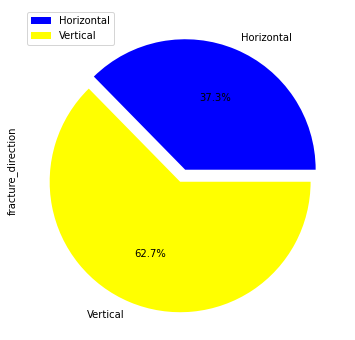

In [14]:
# plot a pie chart
df_fractures_counted.plot(kind='pie', autopct='%1.1f%%', explode=[0, 0.1], colors=['blue', 'yellow'], figsize=(6,6))
plt.legend(loc="upper left")

<a id='3'></a>
## New DS9 Regions File Generation

In [15]:
# open a new file
new_file = open('./output/ds9_physical_new.reg', 'w')

# WCS header
#header = "# Region file format: DS9 version 4.1\nglobal color=green dashlist=8 3 width=1 font=\"helvetica 10 normal roman\" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\nwcs\n"

# physical coordinates header
header = "# Region file format: DS9 version 4.1\nglobal color=green dashlist=8 3 width=1 font=\"helvetica 10 normal roman\" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\nphysical\n"

# write header to the new file
new_file.write(header)

# iterate the datafeame, construct the segments and write into the new file
for index, row in df_fractures.iterrows():
    s_segments = row['segments']
    s_segments_colour = row['segments_color']
    
    #print("# segment(" + s_segments + ") color=" + s_segments_colour + " width=3")
    new_file.write("# segment(" + s_segments + ") color=" + s_segments_colour + " width=3\n")

new_file.close()


<a id='4'></a>
## Drawing Fractures

In [16]:
# Reading the image
image = cv2.imread('Global_20190321_ShapeV20_200kfacets_FB3.png')
# flip the image vertically
# this is beacuse our coordinates are currently presented on the 'Cartesian Coordinates System'
# but in 'Computer Graphics Coordinate System' the coordinates are flipped on the Y axis
image = cv2.flip(image, 0)

In [17]:
# draw lines
for index, row in df_fractures.iterrows():

    # Read segment attribute from the df
    s_segments = row['segments']

    # Converting the string to list
    l_segments = s_segments.split(",")

    # Extract each line's coordinates, color and draw on the image
    for x in range(0, (len(l_segments) - 3), 2):

        X1, Y1, X2, Y2 = int(float(l_segments[x])), int(float(l_segments[x+1])), int(float(l_segments[x+2])), int(float(l_segments[x+3]))

        start_point = (X1, Y1)
        end_point = (X2, Y2)

        if row['segments_color'] == 'blue':
            # Blue color in BGR
            color = (255, 0, 0)
        elif row['segments_color'] == 'yellow':
            # Yellow color in BGR
            color = (0, 255, 255)
        else:
            # White color in BGR
            color = (255, 255, 255)

        # Line thickness
        thickness = 3

        image = cv2.line(image, start_point, end_point, color, thickness)

# flip the image again and write image in a new jpg file
image = cv2.flip(image, 0)
cv2.imwrite('./output/bennu_directions_classified.jpg', image)


True

### Samples from the Output
<img src="in_cell_images/vertical_and_horizontal_1.png">
<img src="in_cell_images/vertical_and_horizontal_2.png">